# Import Modules

In [5]:
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split , LeaveOneOut , KFold 
from sklearn.metrics import recall_score , confusion_matrix , precision_score , accuracy_score , balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import multiprocessing as mp 
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
ret_dict =  {
    'clf' : False , 
    'prob_table' : True , 
    'acc' : True , 
    'pr_score' : True , 
    'precision' : True , 
    'recall' : True , 
    #'recall' : True ,
}

# Classification with Original data

In [8]:
%%time
from utilities import deets
from choices import get_train_data , param_dict
classes = ['AGN' ,'STAR' , 'YSO' ,  'CV' , 'LMXB' , 'HMXB' ,'ULX','PULSAR']
flag = {
    'conf_flag' : 0 , 
    'streak_src_flag' : 0 , 
    'extent_flag' : 0 , 
    'pileup_flag' : 0 , 
    }


CPU times: user 17 µs, sys: 7 µs, total: 24 µs
Wall time: 29.6 µs


In [9]:
file = f'compiled_data_v3/imputed_data/x_phot_with_color_minmax_modeimp.csv'
data  = get_train_data(flags = flag, classes= classes , offset = 2, file=file)
deets(data,1)

offset:  	0.000|2.010
singinficance:  1.000|267.938
_____________________________________________________
------------------------------
Number of Objects : 10287
Number of Columns : 49
------------------------------


AGN       4150
STAR      3259
YSO       1347
HMXB       828
ULX        235
CV         198
LMXB       159
PULSAR     111
Name: class, dtype: int64

_____________________________________________________


In [25]:
from utilities import cv
res_no_smote , mem_table , index = cv(
    {'data' : data , 'name' : 'data_trial_with_pl'}, 
    {'model' : 'RF' , 'name' :'RF'} ,
    k=10 , return_dict = ret_dict, save_df=1)

Doing 10 fold cross-validation.


In [26]:
mem_table['name'] = index
mem_table

,name,AGN,CV,HMXB,LMXB,STAR,ULX,YSO
0,2CXO J103241.4+574807,0.62,0.00,0.25,0.02,0.01,0.08,0.02
1,2CXO J053530.9-052543,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,2CXO J002403.7-720423,0.00,0.91,0.02,0.02,0.05,0.00,0.00
3,2CXO J092650.0+123538,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2CXO J175128.0-294034,0.00,0.01,0.00,0.00,0.41,0.00,0.58
...,...,...,...,...,...,...,...,...
963,2CXO J083756.4+145903,1.00,0.00,0.00,0.00,0.00,0.00,0.00
964,2CXO J005619.1-721507,0.11,0.32,0.29,0.08,0.07,0.04,0.09
965,2CXO J104724.2+591231,0.58,0.02,0.37,0.01,0.01,0.01,0.00
966,2CXO J064104.5+093013,0.00,0.02,0.00,0.02,0.92,0.00,0.04


In [28]:
mprob = mem_table.copy().set_index('name')
mprob = mprob.rename(columns = {
    'AGN' :'P_agn' , 
    'CV' :'P_cv' , 
    'LMXB' : 'P_lmxb' , 
    'STAR' : 'P_star' , 
    'ULX' : 'P_ulx' , 
    'YSO' : 'P_yso'
})
p_margin = []
for i in range(len(mprob)):
    p_margin.append(np.amax(mprob.iloc[i]))
#p_margin = [np.amax(el) for el in mprob]
mprob.insert(0 , 'predicted class'  , res_no_smote['prob_table']['pred_class'])
mprob.insert(0 , 'predicted Prob'  , p_margin)
mprob.to_csv('predicted_table.csv')

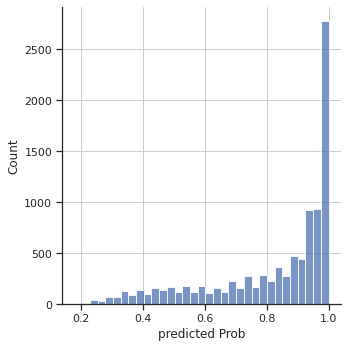

In [29]:
sns.displot(
    data = mprob , 
    x = 'predicted Prob'
)
plt.show()

In [30]:
res_no_smote['pr_score']

,class,precision,recall
0,AGN,0.942712,0.972569
1,STAR,0.937815,0.951148
2,CV,0.592965,0.578431
3,YSO,0.942878,0.922351
4,ULX,0.578723,0.482270
5,HMXB,0.832126,0.734542
6,LMXB,0.729560,0.872180


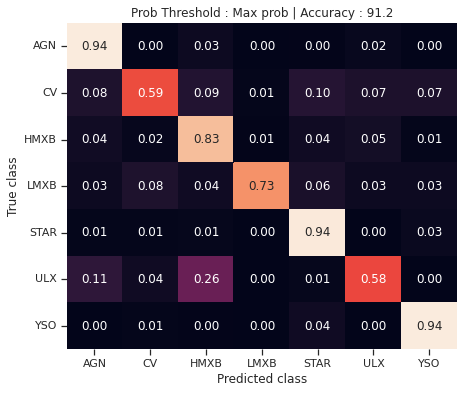

In [31]:
from utilities import plot_cf
plot_cf('data_trial_with_pl' , 'RF' , k=10)
#plt.savefig('plots/cf_with_smote.png')

In [32]:
res_no_smote['pr_score']

,class,precision,recall
0,AGN,0.942712,0.972569
1,STAR,0.937815,0.951148
2,CV,0.592965,0.578431
3,YSO,0.942878,0.922351
4,ULX,0.578723,0.482270
5,HMXB,0.832126,0.734542
6,LMXB,0.729560,0.872180


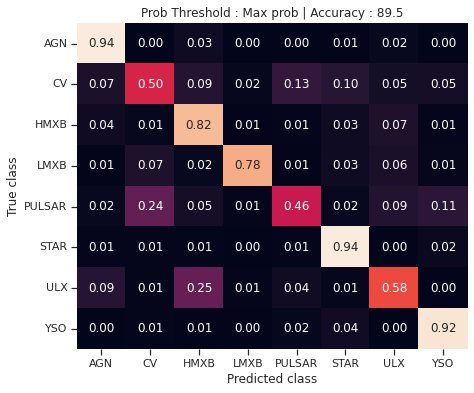

In [22]:
from utilities import plot_cf
plot_cf('data_trial' , 'RF' , k=10)

In [27]:
res_no_smote['pr_score'].insert(0 , 'upsample' , 'No Upsample')

In [29]:
res = pd.concat([res_no_smote['pr_score'] , res_smote['pr_score']])
res 

,upsample,class,precision,recall
0,No Upsample,HMXB,0.832440,0.807542
1,No Upsample,AGN,0.967019,0.938449
2,No Upsample,STAR,0.958318,0.940078
3,No Upsample,YSO,0.931699,0.913305
4,No Upsample,ULX,0.478673,0.668874
5,No Upsample,CV,0.427711,0.780220
6,No Upsample,LMXB,0.713287,0.962264
0,SMOTE,AGN,0.933192,0.960400
1,SMOTE,STAR,0.943227,0.957680
2,SMOTE,YSO,0.922942,0.921329


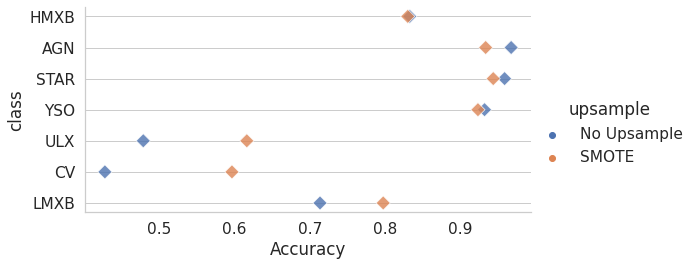

In [40]:
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set(font_scale=1.4, rc={'axes.facecolor':'white', 'figure.facecolor':'white' ,} , style = 'whitegrid')
#sns.set(font_scale = 1.2)
sns.relplot(
    data = res , 
    kind= 'scatter',
    hue = 'upsample' ,
    x = 'precision' ,
    y = 'class',
    #palette=sns.color_palette('icefire' , 2 , ),#hls
    #line=False,
    #saturation=.3,
    height= 4 , 
    aspect = 12/6,
    alpha = 0.8, s=100 , marker = 'D'
)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
plt.xlabel('Accuracy')
#plt.gca().xaxis.grid(True)
plt.savefig('plots/smote_comparison.png')
plt.show()

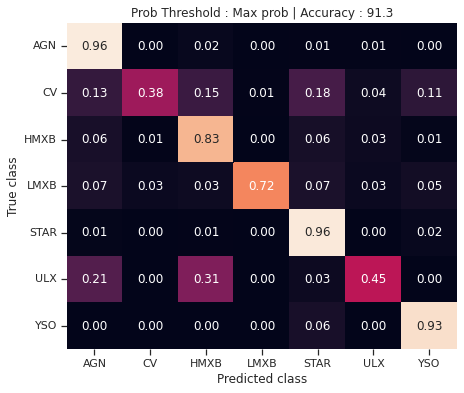

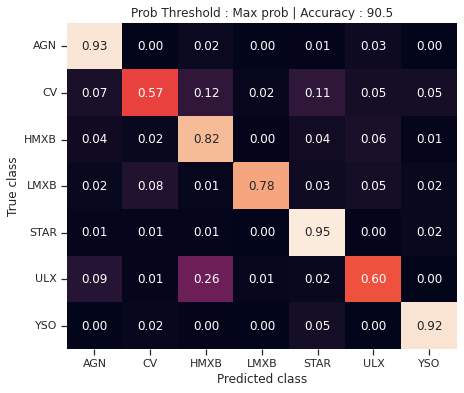

In [16]:
from utilities import plot_cf
plot_cf('data' , 'RF_smote' , k=10)

In [6]:
print(res['acc'] , res['precision'] , res['recall'])

0.915299100052938 0.8615613199912254 0.7569980345768208


In [84]:


print(res['acc'] , res['precision'] , res['recall'])

0.9039174166225517 0.7823065834539139 0.7945092912565739


In [ ]:
precision_score()

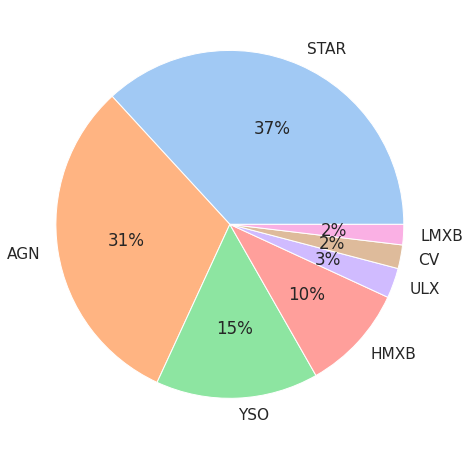

In [66]:
colors = sns.color_palette('pastel')[0:8]

#create pie chart
plt.figure(figsize=(8,8))
plt.pie(cl['class'], labels = cl['index'], colors = colors, autopct='%.0f%%')
plt.savefig('plots/pie-chart.png')
plt.show()

In [68]:
res 

{'prob_table':      true_class pred_class  pred_prob
 0           AGN        AGN       0.71
 1          STAR       STAR       1.00
 2          STAR       STAR       1.00
 3          STAR       STAR       1.00
 4           AGN        AGN       0.96
 ...         ...        ...        ...
 7551        AGN        AGN       0.89
 7552       STAR       STAR       0.96
 7553        AGN        AGN       0.92
 7554       STAR       STAR       0.79
 7555        AGN        AGN       0.93
 
 [7556 rows x 3 columns],
 'acc': 0.9060349391212281,
 'pr_score':   class  precision    recall
 0   AGN   0.932347  0.961203
 1  STAR   0.947179  0.953690
 2   ULX   0.592417  0.478927
 3   YSO   0.925569  0.925569
 4  HMXB   0.821716  0.777919
 5    CV   0.590361  0.535519
 6  LMXB   0.783217  0.903226}

# Imputation study

In [ ]:
imp_type = ['1itrrf' , 'mode' , 'mean' , 'median' , '0' , '-100' , '-200']
pr_table = []
acc = {}
for i in imp_type:
    print(i)
    file = f'compiled_data/imputed/x_phot_with_color_minmax_{i}imp.csv'
    data = get_train_data(flags = flag, classes= classes , offset = 1, file=file)
    #data = data.replace({'PULSAR' : 'LMXB'})
    #data = data.drop(columns = param_dict['model_fit'])
    #data = data.drop(columns = param_dict['hard_var_col'])
    #deets(data , 1,)
    from utilities import cv
    res = cv(
        {'data' : data , 'name' : 'data_clean_cat'}, 
        {'model' : 'RF' , 'name' :'RF'} ,
        k=10 , return_dict = ret_dict)
    print(res['acc'])
    pr = res['pr_score'].sort_values(by='precision')
    pr['imp_type'] = i
    pr_table.append(pr)
    acc[i] = res['acc']
    print('----------------')

In [203]:
acc_df = pd.DataFrame({
    'class': 'Overall' , 
    'imp_type' : acc.keys() , 
    'precision' : acc.values()
})
acc_df

,class,imp_type,precision
0,Overall,1itrrf,0.901668
1,Overall,mode,0.906564
2,Overall,mean,0.904182
3,Overall,median,0.908947
4,Overall,0,0.877845
5,Overall,-100,0.821996
6,Overall,-200,0.787321


In [307]:
pr_df = pd.concat(pr_table).append(acc_df).replace('1itrrf' , 'iter RF')
pr_df.to_csv('validation_res/imp_comparison/pr.csv')

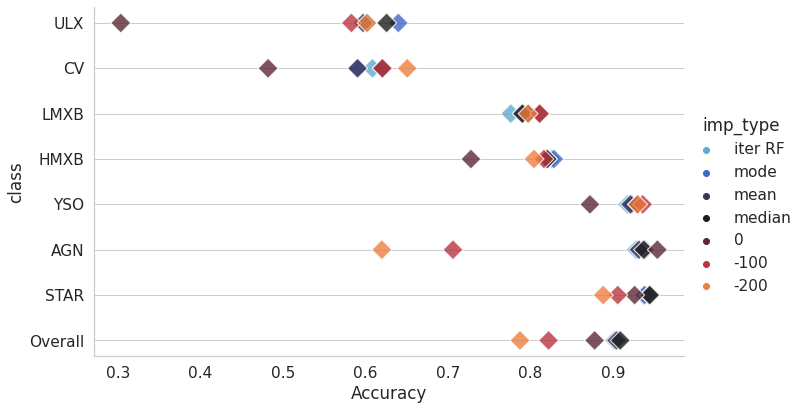

In [39]:
scatter_kws={"alpha":0.3,"s":200}
import pandas as pd 
pr_df = pd.read_csv('validation_res/imp_comparison/pr.csv')
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set(font_scale=1.4, rc={'axes.facecolor':'white', 'figure.facecolor':'white' ,} , style = 'whitegrid')
#sns.set(font_scale = 1.2)
sns.relplot(
    data = pr_df , 
    kind= 'scatter',
    hue = 'imp_type' ,
    x = 'precision' ,
    y = 'class',
    palette=sns.color_palette('icefire' , 7 , ),#hls
    #line=False,
    #saturation=.3,
    height=6 , 
    aspect = 10/6,
    alpha = 0.8, s=200 , marker = 'D'
)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
plt.xlabel('Accuracy')
#plt.gca().xaxis.grid(True)
plt.savefig('plots/imp_comparison.png')
plt.show()

# Hyper Parameter tuning

In [138]:
from utilities import deets
from choices import get_train_data
classes = ['AGN' ,'STAR' , 'YSO' , 'CV' , 'LMXB' , 'HMXB' ,'ULX']
flag = {
    'conf_flag' : 0 , 
    'streak_src_flag' : 0 , 
    'extent_flag' : 0 , 
    'pileup_flag' : 0 , 
    }
ret_dict =  {
    'clf' : False , 
    'prob_table' : True , 
    'acc' : True , 
    'pr_score' : True , 
    #'recall' : True ,
    'recall' : False ,
    'precision' : False
}

### Num_trees

In [139]:
%%time
from utilities import cv 
from choices import param_dict
def tune(sig):
    data = get_train_data(flags = flag, classes= classes , sig = 0 , offset=1)
    data = data.drop(columns = param_dict['hardness'])
    clf = RandomForestClassifier(
        n_estimators = sig 
    )
    res = cv(
        {'data' : data , 'name' : 'data'} , 
        {'model' : 'RF' , 'name' : 'RF'}, 
        k=10, return_dict = ret_dict)
    return res["acc"] , res['pr_score']
tree_arr = [50 , 100 , 150 , 300 , 400 , 500 , 700 , 900 , 1200]
tune_res_tree = [tune(s) for s in tree_arr]


Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
CPU times: user 4.31 s, sys: 4.88 s, total: 9.19 s
Wall time: 1min 20s


,num_trees,Overall,AGN,STAR,ULX,YSO,HMXB,CV,LMXB
0,50,0.910005,0.947146,0.940352,0.630332,0.925569,0.820375,0.614458,0.804196
1,100,0.910799,0.947569,0.939633,0.663507,0.922942,0.825737,0.596386,0.818182
2,150,0.911726,0.947146,0.940711,0.658768,0.931699,0.827078,0.590361,0.790210
3,300,0.907094,0.943763,0.938556,0.639810,0.922942,0.812332,0.602410,0.804196
4,400,0.909211,0.945455,0.941789,0.644550,0.916813,0.821716,0.620482,0.797203
5,500,0.911858,0.949260,0.938196,0.644550,0.933450,0.825737,0.602410,0.811189
6,700,0.909608,0.945877,0.942867,0.625592,0.926445,0.813673,0.590361,0.818182
7,900,0.910005,0.946300,0.939993,0.639810,0.924694,0.819035,0.620482,0.818182
8,1200,0.912520,0.945455,0.940711,0.654028,0.933450,0.832440,0.608434,0.804196


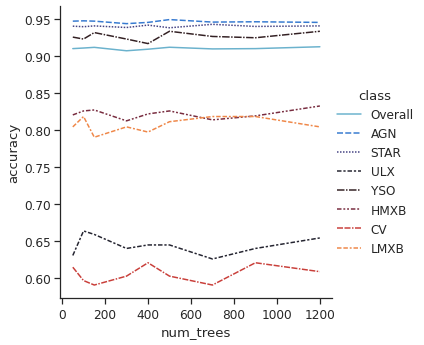

In [144]:
from utilities import tune_res_plot
res = tune_res_plot(tune_res_tree , {'name' : 'num_trees' , 'val' : tree_arr})
plt.savefig('plots/num_tree.png')
res.to_csv('tune/num_tree.csv')
res

### Max depth

In [146]:
%%time
from utilities import cv 
from choices import param_dict
def tune(p):
    data = get_train_data(flags = flag, classes= classes , sig = 0 , offset=1)
    data = data.drop(columns = param_dict['hardness'])
    clf = RandomForestClassifier(
        n_estimators = 150 , 
        max_depth = p
    )
    res = cv(
        {'data' : data , 'name' : 'data'} , 
        {'model' : 'RF' , 'name' : 'RF'}, 
        k=10, return_dict = ret_dict)
    return res["acc"] , res['pr_score']
p_arr = [10 , 20 , 30 , 40 , 50 , 100 , 120]
tune_res_depth = [tune(pi) for pi in p_arr]


Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
CPU times: user 3.34 s, sys: 3.33 s, total: 6.67 s
Wall time: 1min 2s


,Max depth,Overall,STAR,AGN,ULX,LMXB,HMXB,YSO,CV
0,10,0.909476,0.941071,0.944609,0.630332,0.797203,0.829759,0.922067,0.602410
1,20,0.908947,0.937478,0.943763,0.658768,0.797203,0.831099,0.921191,0.614458
2,30,0.913446,0.941430,0.949260,0.658768,0.818182,0.825737,0.929947,0.620482
3,40,0.912388,0.937837,0.951374,0.635071,0.811189,0.825737,0.931699,0.626506
4,50,0.910799,0.941430,0.944609,0.663507,0.783217,0.816354,0.930823,0.626506
5,100,0.910005,0.940352,0.945455,0.635071,0.797203,0.816354,0.937828,0.572289
6,120,0.905506,0.936040,0.944609,0.644550,0.825175,0.809651,0.916813,0.590361


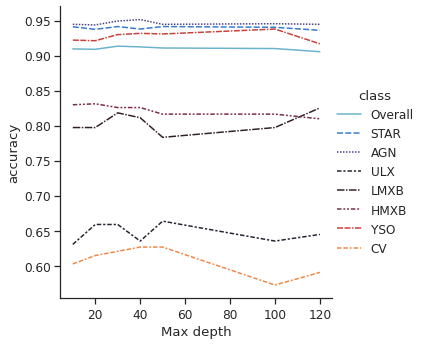

In [147]:
from utilities import tune_res_plot
res = tune_res_plot(tune_res_depth , {'name' : 'Max depth' , 'val' : p_arr})
plt.savefig('plots/max_depth.png')
res.to_csv('tune/max_depth.csv')
res

# Data tuning

In [2]:
from utilities import deets
from choices import get_train_data
classes = ['AGN' ,'STAR' , 'YSO' , 'PULSAR' , 'CV' , 'LMXB' , 'HMXB' ,'ULX']
flag = {
    'conf_flag' : 0 , 
    'streak_src_flag' : 0 , 
    'extent_flag' : 0 , 
    'pileup_flag' : 0 , 
    }
ret_dict =  {
    'clf' : False , 
    'prob_table' : True , 
    'acc' : True , 
    'pr_score' : True , 
    #'recall' : True ,
}

### Significance

In [5]:
%%time
from utilities import cv 
from choices import param_dict
def tune(sig):
    data = get_train_data(flags = flag, classes= classes , sig = sig , offset=1)
    data = data.drop(columns = param_dict['model_fit'])
    res = cv(
        {'data' : data , 'name' : 'data'} , 
        {'model' : 'RF' , 'name' : 'RF'}, 
        k=10, return_dict = ret_dict)
    return res["acc"] , res['pr_score']
sig_arr = [0,1,2,3,4,5]
tune_res = [tune(s) for s in sig_arr]


Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
CPU times: user 3.82 s, sys: 2.42 s, total: 6.23 s
Wall time: 2min 55s


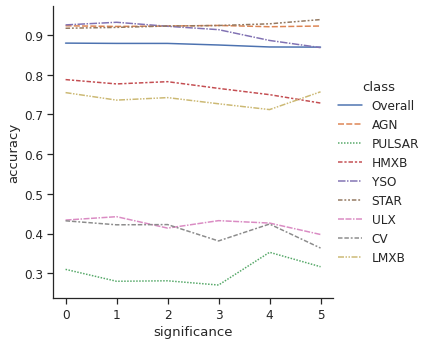

,significance,Overall,AGN,PULSAR,HMXB,YSO,STAR,ULX,CV,LMXB
0,0,0.879252,0.922891,0.310000,0.787440,0.925074,0.916637,0.434043,0.432161,0.754717
1,1,0.878525,0.921199,0.280000,0.776570,0.931700,0.918793,0.442553,0.422111,0.735849
2,2,0.878482,0.922249,0.281250,0.782238,0.921584,0.922234,0.413793,0.422680,0.742138
3,3,0.874507,0.923679,0.270588,0.765333,0.913091,0.923529,0.432558,0.381503,0.726619
4,4,0.869540,0.920483,0.352941,0.749583,0.885965,0.927830,0.426471,0.424051,0.712000
5,5,0.869172,0.922260,0.316667,0.728421,0.867876,0.938453,0.397727,0.363636,0.756757


In [9]:
from utilities import tune_res_plot
res = tune_res_plot(tune_res , {'name' : 'significance' , 'val' : sig_arr})
res.to_csv('tune/sig.csv')
res

### Offset

In [16]:
%%time
from utilities import cv 
from choices import param_dict , get_train_data
def tune(off):
    data = get_train_data(flags = flag, classes= classes , sig = 0 , offset=off)
    #data = data.drop(columns = param_dict['model_fit'])
    res = cv(
        {'data' : data , 'name' : 'data'} , 
        {'model' : 'RF' , 'name' : 'RF'}, 
        k=10, return_dict = ret_dict)
    return res["acc"] , res['pr_score']
off_arr = [1,2,3,4]
tune_res = [tune(s) for s in off_arr]


Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
Doing 10 fold cross-validation.
CPU times: user 1.96 s, sys: 1.62 s, total: 3.58 s
Wall time: 52 s


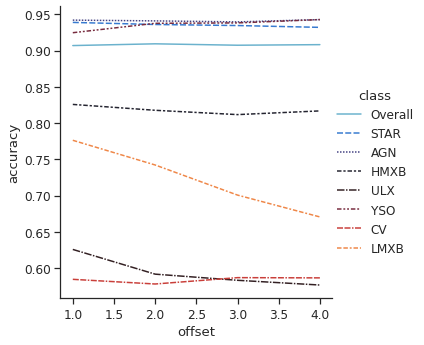

,offset,Overall,STAR,AGN,HMXB,ULX,YSO,CV,LMXB
0,1,0.906961,0.938915,0.942072,0.825737,0.625592,0.924694,0.584337,0.776224
1,2,0.909382,0.936040,0.941020,0.817633,0.591489,0.937685,0.577889,0.742138
2,3,0.907427,0.934603,0.939627,0.811681,0.582996,0.938229,0.586667,0.700599
3,4,0.908234,0.932088,0.942797,0.816785,0.576471,0.942821,0.586345,0.670455


In [23]:
from utilities import tune_res_plot
#tune_res = pd.read_csv('tune/offset.csv')
res = tune_res_plot(tune_res , {'name' : 'offset' , 'val' : [1,2,3,4]})
res.to_csv('tune/offset.csv')
res

# Feature modification

# Feature Importance

In [3]:
from utilities import deets
from choices import get_train_data
classes = ['AGN' ,'STAR' , 'YSO' ,  'CV' , 'LMXB' , 'HMXB' ,'ULX' ,'PULSAR']
flag = {
    'conf_flag' : 0 , 
    'streak_src_flag' : 0 , 
    'extent_flag' : 0 , 
    'pileup_flag' : 0 , 
    }
ret_dict =  {
    'clf' : False , 
    'prob_table' : True , 
    'acc' : True , 
    'pr_score' : True , 
    #'recall' : True ,
}

max offset: 9.998529125027682
max offset: 267.9379420657924
max offset: 2.0095520376532923
max offset: 267.9379420657924


In [4]:
from choices import param_dict
data = get_train_data(flags = flag, classes= classes , sig = 0 , offset=1)
deets(data,1)
df_dict = {
    'All_feat': data , 
    'no_mw' : data.drop(columns = param_dict['MW']) , 
    'no_color' : data.drop(columns = param_dict['color']) , 
    'no_gaia_no_col' : data.drop(columns = param_dict['GAIA']+param_dict['color']) ,
}

max offset: 1.009714527096731
max offset: 267.9379420657924
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 49
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________


In [154]:
ret_dict =  {
    'clf' : False , 
    'prob_table' : False , 
    'acc' : True , 
    'pr_score' : True , 
    'precision' : False , 
    'recall' : False ,
    #'recall' : True ,
    'roc_auc_score' : False
}

In [155]:
%%time
from utilities import cv 
from choices import param_dict
def tune(f):
    res , _ ,_= cv(
        {'data' : df_dict[f] , 'name' :f} , 
        {'model' : 'RF' , 'name' : 'RF'}, 
        k=10, return_dict = ret_dict , save_df=1)
    res['pr_score'].insert(0 , 'Feature dropped' , f)
    return res["acc"] , res['pr_score']
tune_res = [tune(f) for f in df_dict.keys()]


Doing 10 fold cross-validation.
Overall Accuracy : 0.8945865247306244
Doing 10 fold cross-validation.
Overall Accuracy : 0.8259119823445411
Doing 10 fold cross-validation.
Overall Accuracy : 0.8948461638322731
Doing 10 fold cross-validation.
Overall Accuracy : 0.8913410359600156
CPU times: user 1.19 s, sys: 2.91 s, total: 4.1 s
Wall time: 43.4 s


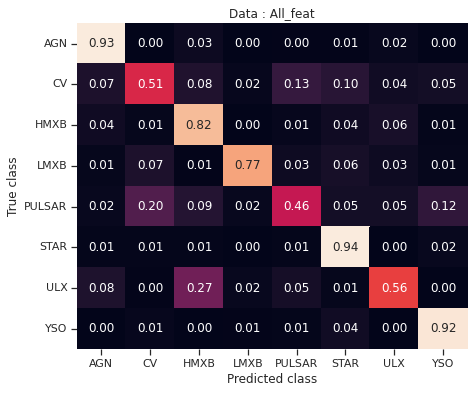

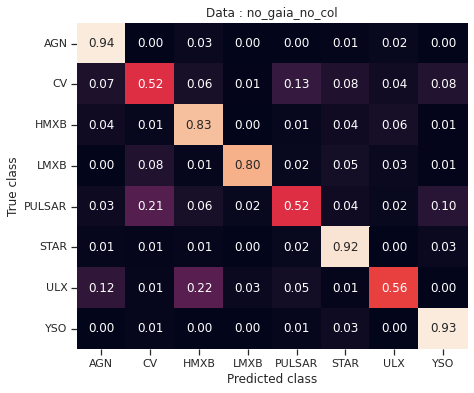

In [161]:
for f in ['All_feat' , 'no_gaia_no_col']:
    plot_cf(f , 'RF' , k=10)
    plt.title(f'Data : {f}')
    plt.show()

In [157]:
acc = [el[0] for el in tune_res]
pr = pd.concat([el[1] for el in tune_res])
#pr = pr[pr['Feature dropped']!='no_mw']

In [158]:
d = []
db = pr[pr['Feature dropped']=='no_feat_drop']
for f in pr['Feature dropped'].unique():
    temp = pr[pr['Feature dropped']==f]
    temp.loc[: , 'precision'] = temp['precision'] - db['precision']
    display(temp)
    d.append(temp)

/home/shivam/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Feature dropped,class,precision,recall
0,All_feat,HMXB,NaN,0.772898
1,All_feat,AGN,NaN,0.962995
2,All_feat,STAR,NaN,0.953370
3,All_feat,CV,NaN,0.488372
4,All_feat,YSO,NaN,0.917820
5,All_feat,LMXB,NaN,0.833333
6,All_feat,PULSAR,NaN,0.319444
7,All_feat,ULX,NaN,0.510730


/home/shivam/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Feature dropped,class,precision,recall
0,no_mw,HMXB,NaN,0.762500
1,no_mw,AGN,NaN,0.913580
2,no_mw,STAR,NaN,0.899655
3,no_mw,YSO,NaN,0.804706
4,no_mw,LMXB,NaN,0.884615
5,no_mw,CV,NaN,0.437811
6,no_mw,ULX,NaN,0.281588
7,no_mw,PULSAR,NaN,0.170213


/home/shivam/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Feature dropped,class,precision,recall
0,no_color,AGN,NaN,0.959488
1,no_color,YSO,NaN,0.917749
2,no_color,STAR,NaN,0.958057
3,no_color,HMXB,NaN,0.781609
4,no_color,LMXB,NaN,0.848485
5,no_color,CV,NaN,0.470899
6,no_color,ULX,NaN,0.523605
7,no_color,PULSAR,NaN,0.297297


/home/shivam/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,Feature dropped,class,precision,recall
0,no_gaia_no_col,AGN,NaN,0.956911
1,no_gaia_no_col,ULX,NaN,0.512931
2,no_gaia_no_col,STAR,NaN,0.957662
3,no_gaia_no_col,YSO,NaN,0.909322
4,no_gaia_no_col,CV,NaN,0.472826
5,no_gaia_no_col,HMXB,NaN,0.789072
6,no_gaia_no_col,PULSAR,NaN,0.306358
7,no_gaia_no_col,LMXB,NaN,0.850746


In [24]:
prd = pd.concat(d)
#prd = prd[prd['Feature dropped']!='no_mw']

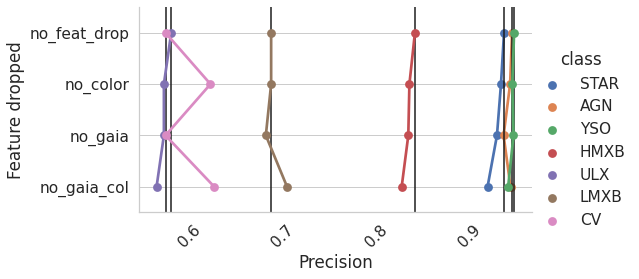

In [25]:
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set(font_scale=1.4, rc={'axes.facecolor':'white', 'figure.facecolor':'white' ,} , style = 'whitegrid')
#sns.set(font_scale = 1.2)
sns.catplot(
    data = pr[pr['Feature dropped']!='no_mw'] , 
    kind= 'point',
    y= 'Feature dropped' ,
    x = 'precision' ,
    hue = 'class',
    #palette=sns.color_palette('icefire' ,7),#hls
    #line=False,
    #saturation=.3,
    height= 4 , 
    aspect = 12/6,
    #alpha = 0.9, s=100 , marker = 'o'
)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
plt.xlabel('Precision')
plt.xticks(rotation = 45)
#plt.gca().xaxis.grid(True)
#plt.savefig('plots/feature_importance.png')
for p in pr[pr['Feature dropped']=='no_feat_drop']['precision'].to_list():
    plt.axvline(p ,color='k')
#plt.savefig('plots/feat_imp.png')
plt.show()

In [134]:
color

AttributeError: '_ColorPalette' object has no attribute 'val'

In [127]:
pr_base = pr[pr['Feature dropped']=='no_feat_drop']
pr_base

,Feature dropped,class,precision,recall
0,no_feat_drop,STAR,0.942508,0.954165
1,no_feat_drop,AGN,0.941649,0.960328
2,no_feat_drop,YSO,0.924694,0.922271
3,no_feat_drop,HMXB,0.823056,0.775253
4,no_feat_drop,ULX,0.616114,0.530612
5,no_feat_drop,LMXB,0.797203,0.850746
6,no_feat_drop,CV,0.602410,0.581395


In [55]:
pr[pr['class']=='CV'].sort_values(by='precision')

,Feature dropped,class,precision,recall
4,no_color,CV,0.566265,0.556213
6,no_optical_uv,CV,0.596386,0.502538
4,no_hardness,CV,0.596386,0.529412
6,no_feat_drop,CV,0.602410,0.581395
5,no_var,CV,0.602410,0.588235
6,no_IR,CV,0.620482,0.613095


In [56]:
pr[pr['class']=='ULX'].sort_values(by='precision')

,Feature dropped,class,precision,recall
6,no_var,ULX,0.597156,0.547826
4,no_feat_drop,ULX,0.616114,0.530612
6,no_color,ULX,0.616114,0.515873
4,no_IR,ULX,0.616114,0.539419
6,no_hardness,ULX,0.649289,0.533074
5,no_optical_uv,ULX,0.668246,0.440625


# Final results

In [72]:
%%time
from utilities import deets
from choices import get_train_data , param_dict
classes = ['AGN' ,'STAR' , 'YSO' ,  'CV' , 'LMXB' , 'HMXB' ,'ULX','PULSAR']
flag = {
    'conf_flag' : 0 , 
    'streak_src_flag' : 0 , 
    'extent_flag' : 0 , 
    'pileup_flag' : 0 , 
    }


CPU times: user 36 µs, sys: 0 ns, total: 36 µs
Wall time: 44.1 µs


In [73]:
ret_dict= {'clf': False,
 'prob_table': True,
 'acc': True,
 'pr_score': True,
 'precision': True,
 'recall': True}

In [74]:
file = f'compiled_data_v3/imputed_data/x_phot_with_color_minmax_modeimp.csv'
data = get_train_data(flags = flag, classes= classes , offset = 1, file=file)
data = data.drop(columns = param_dict['hardness'])
deets(data,1)
from utilities import cv
res_final , _ , _  = cv(
    {'data' : data , 'name' : 'data_trial'}, 
    {'model' : 'RF' , 'name' :'RF'} ,
    k=20 , return_dict = ret_dict, save_df=1)

max offset: 1.009714527096731
max offset: 267.9379420657924
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 46
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
Doing 20 fold cross-validation.


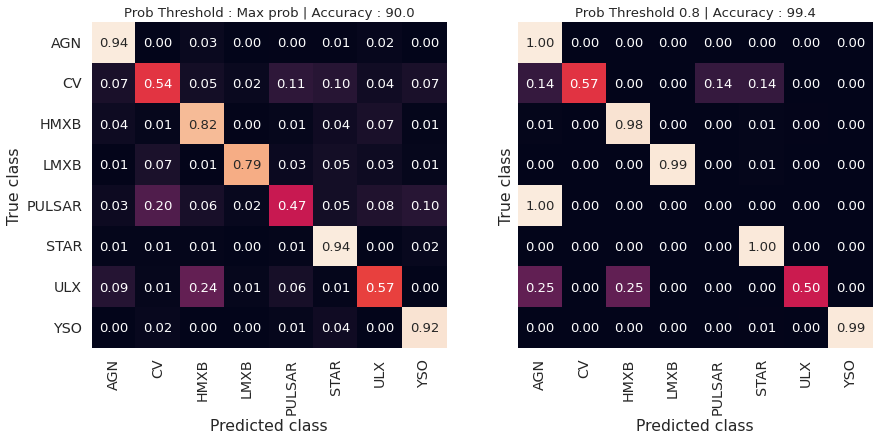

In [75]:
from utilities import plot_cf
plot_dict_def = {
    'title' : True , 
    'font_scale' : 1.1 , 
    'cbar' : False ,
    'plot_num' : False,
}
fig , ax = plt.subplots(nrows=1, ncols=2, figsize = (14,6) , sharex=True , sharey=True,)
plot_cf('data_trial' , 'RF' , k=20 ,ax=ax[0] ,plot_dict=plot_dict_def)
plot_cf('data_trial' , 'RF' , k=20 ,ax=ax[1] ,plot_dict=plot_dict_def , confidance=0.8)
#plt.savefig('plots/final_cf_comp.eps')
plt.show()

In [76]:
pred = res_final['prob_table']
def calc_acc(th):
    pred_th = pred[pred['pred_prob']>th]
    acc_th = accuracy_score(pred_th['true_class'] , pred_th['pred_class'])
    frac = len(pred_th) / len(pred)
    return np.asarray([acc_th , frac])
th_arr = np.linspace(pred['pred_prob'].min(),0.9)
a = np.asarray([calc_acc(i) for i in th_arr])


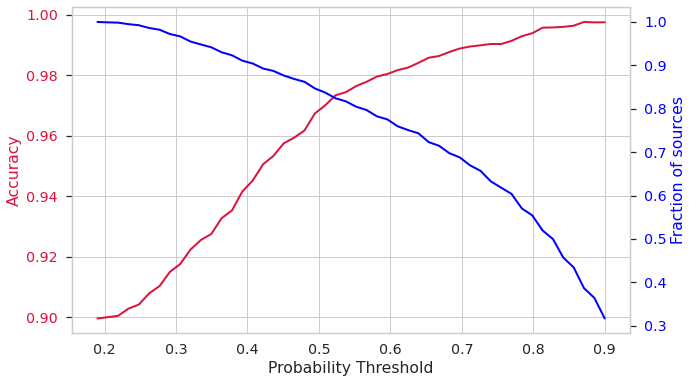

In [77]:
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1)
plt.plot(th_arr, a[:,0], "b-", linewidth=2 , label = 'Accuracy' , color='crimson')
plt.ylabel('Accuracy' , color='crimson')
plt.xlabel('Probability Threshold')
plt.tick_params(axis="y", labelcolor="crimson", pad=8)
ax2 = plt.twinx()
c2 = 'blue'
plt.plot(th_arr , a[:,1], "r-", linewidth=2 , label = 'Fraction of sources' , color=c2)
plt.ylabel('Fraction of sources' , color=c2)
plt.tick_params(axis="y", labelcolor=c2, pad=8)
plt.grid()
#plt.legend()
#plt.savefig('plots/th_study.png')
plt.show()

In [16]:
#res_final['pr_score'].to_csv('pres_recall.csv' ,  float_format='%.2f')

In [78]:
res_final['acc']

0.8995196676619499

# Finding Best Model

In [5]:
%%time
from utilities import deets , cv
from choices import get_train_data , param_dict
classes = ['AGN' ,'STAR' , 'YSO' ,  'CV' , 'LMXB' , 'HMXB' ,'ULX','PULSAR']
flag = {
    'conf_flag' : 0 , 
    'streak_src_flag' : 0 , 
    'extent_flag' : 0 , 
    'pileup_flag' : 0 , 
    }
file = f'compiled_data_v3/imputed_data_v2/x_phot_minmax_modeimp.csv'
data = get_train_data(flags = flag, classes= classes , offset = 1, file=file)
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC'])
columns = param_dict['hardness']+param_dict['IRAC']
#feat_to_drop = np.unique(param_dict['hardness'])
data = data.drop(columns = columns)
deets(data,1)

offset:  	0.000|9.999
singinficance:  0.870|267.938
offset:  	0.000|2.010
singinficance:  3.000|267.938
offset:  	0.000|1.010
singinficance:  1.000|267.938
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 42
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
CPU times: user 1.19 s, sys: 139 ms, total: 1.33 s
Wall time: 1.33 s


In [6]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier , GradientBoostingClassifier 

hist =  HistGradientBoostingClassifier(verbose = 1 , max_iter = 50)
gb = GradientBoostingClassifier()
x = data.drop(columns=['class'])
y = data['class']
x_train,x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2 , stratify=y)


In [7]:
x_up , y_up = SMOTE().fit_resample(x_train , y_train)
gb.fit(x_up, y_up)
gb.score(x_test,y_test)

KeyboardInterrupt: 

In [6]:
from imblearn.over_sampling import SMOTE 
x_up , y_up = SMOTE().fit_resample(x_train , y_train)
hist.fit(x_up , y_up)
hist.score(x_test , y_test)

Binning 0.005 GB of training data: 2.340 s
Binning 0.001 GB of validation data: 2.222 s
Fitting gradient boosted rounds:
[1/50] 8 trees, 248 leaves (31 on avg), max depth = 13, train loss: 1.54264, val loss: 1.54489, in 102.685s
[2/50] 8 trees, 248 leaves (31 on avg), max depth = 17, train loss: 1.25406, val loss: 1.26671, in 103.164s
[3/50] 8 trees, 248 leaves (31 on avg), max depth = 17, train loss: 1.05069, val loss: 1.07156, in 63.653s
[4/50] 8 trees, 248 leaves (31 on avg), max depth = 16, train loss: 0.89494, val loss: 0.92434, in 103.646s
[5/50] 8 trees, 248 leaves (31 on avg), max depth = 15, train loss: 0.77263, val loss: 0.80922, in 104.548s
[6/50] 8 trees, 248 leaves (31 on avg), max depth = 17, train loss: 0.67539, val loss: 0.71756, in 107.267s
[7/50] 8 trees, 248 leaves (31 on avg), max depth = 19, train loss: 0.59462, val loss: 0.64034, in 104.866s
[8/50] 8 trees, 248 leaves (31 on avg), max depth = 15, train loss: 0.52660, val loss: 0.57503, in 105.602s
[9/50] 8 trees, 

0.9136924075275795

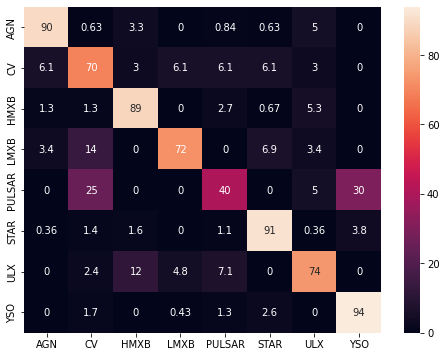

In [52]:
gb_pred = gb.predict(x_test)
label = np.unique(y_test)
cm = confusion_matrix(y_test , gb.predict(x_test) , normalize='true', labels=label)
plt.figure(figsize=(8,6))
sns.heatmap(cm*100 , annot=True , xticklabels=label , yticklabels=label)
plt.show()

In [43]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',])
deets(df,1)
y = df['class']
x = df[x_col]
x = x.drop(columns=feat_to_drop)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________


In [44]:
x

,gal_b2,gal_l2,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J002359.4-720438,2.487849,8.497420,2.632625,0.000904,5.046627,0.00,8.195828,1.0,1.499984e-09,0.000345,...,4.784757,2.894845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J174041.4-534004,4.327881,9.393618,9.999996,0.017956,1.995495,10.00,8.236122,0.0,1.102579e-07,0.054905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J002409.2-720543,2.488746,8.496825,9.999844,0.001090,6.298061,7.50,8.909807,1.0,8.495617e-10,0.001753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J002411.1-720620,2.489281,8.496673,8.302307,0.026969,8.383567,6.25,9.841010,2.0,9.022461e-10,0.004952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J002401.4-720441,2.487878,8.497314,5.005657,0.000442,7.272317,3.75,9.850364,2.0,1.416053e-09,0.000386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J003444.5-431554,0.888957,8.713766,NaN,NaN,3.074255,NaN,0.408315,0.0,NaN,0.010893,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2CXO J203606.3+422737,5.054270,2.262789,NaN,NaN,3.363494,NaN,8.996703,0.0,NaN,0.006719,...,7.935403,4.953001,7.119828,NaN,6.445148,NaN,6.807378,5.048179,NaN,NaN
2CXO J131747.5+411745,9.176328,2.880393,NaN,NaN,1.768983,NaN,2.472603,0.0,9.654383e-08,0.044660,...,8.002279,2.122574,NaN,5.055027,NaN,4.955872,NaN,NaN,NaN,6.731328


In [45]:
from imblearn.over_sampling import SMOTE 
from sklearn.impute import SimpleImputer
x_up , y_up = SMOTE().fit_resample(x_train.replace(np.nan  , -998878) , y_train)
x_up = x_up.replace(-998878 , np.nan)

In [46]:
hist = HistGradientBoostingClassifier(verbose=1 , learning_rate=0.1 , max_iter = 200 , early_stopping=True , n_iter_no_change=10 , random_state=42)
hist.fit(x_up,y_up)

Binning 0.005 GB of training data: 0.212 s
Binning 0.001 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/200] 8 trees, 248 leaves (31 on avg), max depth = 13, train loss: 1.54537, val loss: 1.55627, in 1.833s
[2/200] 8 trees, 248 leaves (31 on avg), max depth = 13, train loss: 1.25412, val loss: 1.27619, in 0.322s
[3/200] 8 trees, 248 leaves (31 on avg), max depth = 14, train loss: 1.05447, val loss: 1.08159, in 0.264s
[4/200] 8 trees, 248 leaves (31 on avg), max depth = 13, train loss: 0.90059, val loss: 0.93285, in 0.324s
[5/200] 8 trees, 248 leaves (31 on avg), max depth = 14, train loss: 0.78146, val loss: 0.81801, in 0.284s
[6/200] 8 trees, 248 leaves (31 on avg), max depth = 13, train loss: 0.68424, val loss: 0.72362, in 0.286s
[7/200] 8 trees, 248 leaves (31 on avg), max depth = 13, train loss: 0.60280, val loss: 0.64512, in 0.505s
[8/200] 8 trees, 248 leaves (31 on avg), max depth = 14, train loss: 0.53462, val loss: 0.57748, in 0.163s
[9/200] 8 trees, 248 le

HistGradientBoostingClassifier(early_stopping=True, max_iter=200,
                               random_state=42, verbose=1)

In [47]:
from sklearn.metrics import confusion_matrix
hist_pred = hist.predict(x_test)


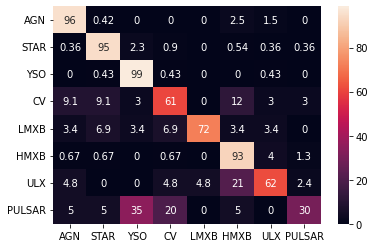

In [48]:
cm = confusion_matrix(y_test , hist.predict(x_test) , normalize='true', labels=classes)
sns.heatmap(cm*100 , annot=True , xticklabels=classes , yticklabels=classes)
plt.show()

In [5]:
ret_dict= {
 'clf': True,
 'prob_table': True,
 'acc': True,
 'pr_score': True,
 'precision': True,
 'recall': True , 
 'roc_auc_score' : True
 }

In [6]:
import sklearn
sklearn.__version__

'0.24.2'

In [23]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostClassifier , BaggingClassifier , ExtraTreesClassifier ,StackingClassifier , VotingClassifier , GradientBoostingClassifier , HistGradientBoostingClassifier
gb = GradientBoostingClassifier()
from sklearn.svm import SVC
from sklearn.linear_model import BayesianRidge 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
RN = 42
model_collection = {
    'base_clf' : {
        'baysian' : GaussianNB() , 
        'br' : BayesianRidge() , 
        'tree' : DecisionTreeClassifier()
    } ,
    'adaboost' : {
        'model' : AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5) , n_estimators=100)
    } , 

    'gb' : {
        'model' :GradientBoostingClassifier(random_state=RN),
        'name' : 'GB'
        } , 
    'bagging' : {
        'model' : BaggingClassifier(random_state=RN) , 
        'name' : 'bagging', 
    } , 
    'extra_tree' : {
        'model' : ExtraTreesClassifier(random_state=RN) , 
        'name' : 'extra_tree', 
    } , 
    'hist_grad' : {
        'model' : HistGradientBoostingClassifier(early_stopping=True , validation_fraction=0.2) , 
        'name' : 'hist_grad', 
    } , 
    # 'stack' :{
    #     'model' : StackingClassifier() , 
    #     'name' : 'stack'
    # }
}


In [24]:
res_hist , _ , _  = cv(
        {'data' : data , 'name' : f'data'}, 
        model_collection['hist_grad']
        ,
        k=10 , return_dict = ret_dict, save_df=0)

Doing 10 fold cross-validation.


Process ForkPoolWorker-217:
Process ForkPoolWorker-233:
Process ForkPoolWorker-220:
Process ForkPoolWorker-219:
Process ForkPoolWorker-223:
Process ForkPoolWorker-226:
Process ForkPoolWorker-228:
Process ForkPoolWorker-222:
Process ForkPoolWorker-230:
Process ForkPoolWorker-212:
Process ForkPoolWorker-240:
Process ForkPoolWorker-239:
Process ForkPoolWorker-216:
Process ForkPoolWorker-231:
Process ForkPoolWorker-234:
Process ForkPoolWorker-225:
Process ForkPoolWorker-235:
Process ForkPoolWorker-224:
Process ForkPoolWorker-211:
Process ForkPoolWorker-236:
Process ForkPoolWorker-229:
Process ForkPoolWorker-237:
Process ForkPoolWorker-218:
Process ForkPoolWorker-214:
Process ForkPoolWorker-227:
Process ForkPoolWorker-213:
Process ForkPoolWorker-238:
Process ForkPoolWorker-232:
Process ForkPoolWorker-215:
Process ForkPoolWorker-221:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most rece

KeyboardInterrupt: 

In [20]:
res  = {}
for m in ['bagging' , 'extra_tree' , 'hist_grad' , 'gb' , 'adaboost']:
    res_ex , _ , _  = cv(
        {'data' : data , 'name' : f'data'}, 
        model_collection[m]
        ,
        k=10 , return_dict = ret_dict, save_df=0)
    res[m] =  res_ex

Doing 10 fold cross-validation.
Overall Accuracy : 0.8738153965987278
Classifier is :  BaggingClassifier(random_state=42)
Doing 10 fold cross-validation.
Overall Accuracy : 0.5370634817603531
Classifier is :  ExtraTreesClassifier(random_state=42)


/home/shivam/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Doing 10 fold cross-validation.


Process ForkPoolWorker-185:
Process ForkPoolWorker-199:
Process ForkPoolWorker-188:
Process ForkPoolWorker-196:
Process ForkPoolWorker-180:
Process ForkPoolWorker-191:
Process ForkPoolWorker-197:
Process ForkPoolWorker-192:
Process ForkPoolWorker-200:
Process ForkPoolWorker-195:
Process ForkPoolWorker-186:
Process ForkPoolWorker-189:
Process ForkPoolWorker-181:
Process ForkPoolWorker-184:
Process ForkPoolWorker-198:
Traceback (most recent call last):
Process ForkPoolWorker-172:
Process ForkPoolWorker-193:
Process ForkPoolWorker-171:
Process ForkPoolWorker-178:
Traceback (most recent call last):
Process ForkPoolWorker-173:
Process ForkPoolWorker-190:
Process ForkPoolWorker-179:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-187:
Process ForkPoolWorker-175:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-176:
Process ForkPoolWorker-194:
Process ForkPoolWorker-177:

KeyboardInterrupt: 

,true_class,pred_class,pred_prob
0,STAR,STAR,0.947338
1,AGN,AGN,0.960258
2,STAR,STAR,0.985463
3,STAR,STAR,0.988498
4,STAR,STAR,0.981017
...,...,...,...
7698,AGN,AGN,0.996974
7699,CV,CV,0.391271
7700,HMXB,HMXB,0.986657
7701,STAR,STAR,0.974222


UnboundLocalError: local variable 'data' referenced before assignment

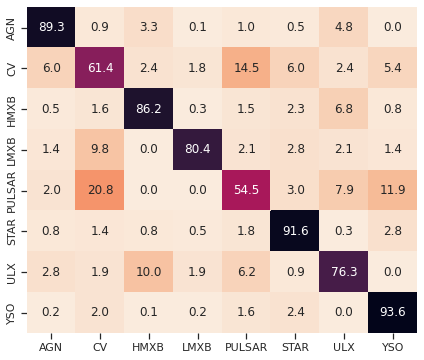

In [15]:
from utilities import plot_cf
plot_cf([res_final['prob_table']])

### Model selection

In [115]:
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
voting = VotingClassifier([('rf' , rf) , ('gb' , gb)] , weights=[0.2, 0.8] , voting='soft')
#clf = Pipeline([('rf', rf)])
clf = Pipeline([('gb', gb)])
clf = Pipeline([('ensamble', voting)])

### Train and validate model

In [116]:
from utilities import cv
ret_dict['clf'] = True
ret_dict['roc_auc_score'] = True
data = {'data' : train_data , 'name' : 'mode_imp'}
model = {'model' : clf , 'name' :'ensemble'}
res_final , mem_table , _  = cv(data, model,k=20 , return_dict = ret_dict, save_df=1)

Doing 20 fold cross-validation.
Overall Accuracy : 0.8956250811372193
Classifier is :  Pipeline(steps=[('ensamble',
                 VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                                              ('gb',
                                               GradientBoostingClassifier())],
                                  voting='soft', weights=[0.2, 0.8]))])


In [117]:
res_final['roc-auc']

0.990775957528293

#### Accuracy check

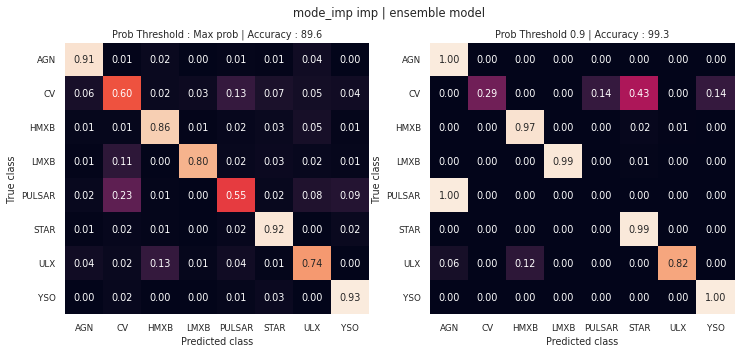

In [118]:
from utilities import plot_cf
plot_dict_def = {
    'title' : True , 
    'font_scale' : 0.8 , 
    'cbar' : False ,
    'plot_num' : False,
}
sns.set(font_scale = 0.8)
fig , ax = plt.subplots(nrows=1, ncols=2, figsize = (12,5) ,  )
plot_cf(data['name'] , model['name'] , k=20 ,ax=ax[0] ,plot_dict=plot_dict_def , confidance=0)
plot_cf(data['name'] , model['name'] , k=20 ,ax=ax[1] ,plot_dict=plot_dict_def , confidance=0.9)
plt.suptitle(f"{data['name']} imp | {model['name']} model")
plt.savefig(f"model_selection/{data['name']}_{model['name']}.png")
plt.show()

## Application

#### Load unidentified dataset

In [119]:
unid_deets = pd.read_csv('compiled_data_v3/id_frame-unid-var-src.csv' , index_col='name')[['ra' , 'dec' ,'missing']]
unid_data = pd.read_csv('compiled_data_v3/imputed_data/unid_phot_with_color_minmax_rfimp.csv' , index_col = 'name').iloc[:,1:]
unid_data = unid_data.drop(columns = cols_to_drop)
deets(unid_data)

_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 45
_____________________________________________________


#### Generate prediction table

In [162]:
clf = res_final['clf']
pred_class = clf.predict(unid_data)
pred_prob_list = clf.predict_proba(unid_data)
pred_prob = [np.amax(el) for el in pred_prob_list]
temp_df = pd.DataFrame(pred_prob_list , columns=clf.classes_)
temp_df.insert(0 , 'name' , unid_data.index.to_list())
temp_df = temp_df.set_index('name')
pred_df = pd.DataFrame({
    'name' : unid_data.index.to_list() , 
    'pred class' : pred_class , 
    'pred prob' : pred_prob 
}).set_index('name')
pred_df = pd.merge(pred_df , temp_df , left_index=True , right_index=True)
pred_df = pd.merge(pred_df , unid_deets , left_index=True , right_index=True)
pred_df.to_csv('mem_table.csv')

In [ ]:
prob_th = [0.5 , 0.75 , 0.8 , 0.9 ,0.95]
tbl = []
tbl = pred_df[pred_df['pred prob']>0]['pred class'].value_counts().to_frame()
tbl = tbl.rename(columns = {'pred class' : f'prob th : {0}'})
for p in prob_th:
    temp = (pred_df[pred_df['pred prob']>p]['pred class'].value_counts().to_frame())
    temp = temp.rename(columns = {'pred class' : f'prob th:{p}'})
    tbl = pd.merge(tbl , temp , left_index = True , right_index =True , how = 'left')

tbl.keys = {'model' : model['name'] , 'data' : data['name']}
tbl.to_csv(f"model_selection/{data['name']}_{model['name']}.csv")
tbl


#### Probability ECDF 

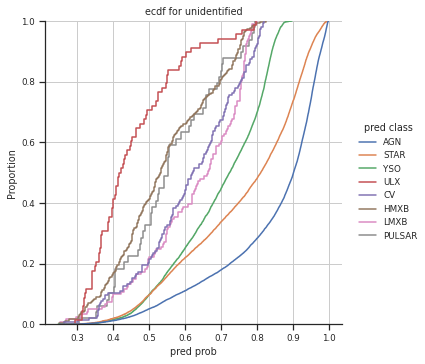

In [121]:
sns.displot(
    data = pred_df , 
    kind = 'ecdf' , 
    x = 'pred prob' , 
    hue ='pred class'
)
plt.title('ecdf for unidentified')
plt.savefig(f"model_selection/prob_{data['name']}_{model['name']}.png")
plt.show()

# Application

### Train Classifier

In [1]:
%%time
from utilities import deets
from choices import get_train_data , param_dict
classes = ['AGN' ,'STAR' , 'YSO' ,  'CV' , 'LMXB' , 'HMXB' ,'ULX','PULSAR']
flag = {
    'conf_flag' : 0 , 
    'streak_src_flag' : 0 , 
    'extent_flag' : 0 , 
    'pileup_flag' : 0 , 
    }


offset:  	0.000|9.999
singinficance:  0.870|267.938
['catalog', 'class', 'significance', 'cat_name', 'var_flag', 'streak_src_flag', 'pileup_flag', 'ra', 'dec', 'offset', 'missing', 'sat_src_flag', 'extent_flag', 'conf_flag', 'cat_ra', 'cat_dec']
True
offset:  	0.000|2.010
singinficance:  3.000|267.938
['catalog', 'class', 'significance', 'cat_name', 'var_flag', 'streak_src_flag', 'pileup_flag', 'ra', 'dec', 'offset', 'missing', 'sat_src_flag', 'extent_flag', 'conf_flag', 'cat_ra', 'cat_dec']
True
CPU times: user 3.36 s, sys: 2.61 s, total: 5.97 s
Wall time: 1.6 s


In [2]:
file = f'compiled_data_v3/imputed_data/x_phot_with_color_minmax_rfimp.csv'
data = get_train_data(flags = flag, classes= classes , offset = 4, file=file)
cols_to_drop = param_dict['hardness']+param_dict['hard_var_col']+param_dict['sparse_col']
cols_to_drop = param_dict['hardness']
data = data.drop(columns = cols_to_drop)
deets(data,1 , 0)

offset:  	0.000|4.006
singinficance:  0.870|267.938
['catalog', 'class', 'significance', 'cat_name', 'var_flag', 'streak_src_flag', 'pileup_flag', 'ra', 'dec', 'offset', 'missing', 'sat_src_flag', 'extent_flag', 'conf_flag', 'cat_ra', 'cat_dec']
True
_____________________________________________________
------------------------------
Number of Objects : 11584
Number of Columns : 46
------------------------------


AGN       4721
STAR      3638
YSO       1573
HMXB       845
ULX        255
CV         248
LMXB       176
PULSAR     128
Name: class, dtype: int64

_____________________________________________________


In [3]:
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
rf = RandomForestClassifier(n_jobs=-1 , n_estimators=500)
gb = GradientBoostingClassifier()
data = data.sample(frac=1)
x = data.drop(columns=['class'])
y = data['class']
from imblearn.over_sampling import SMOTE
#x_up  , y_up = oversample.fit_resample(x,y)
x = SimpleImputer(strategy='most_frequent').fit_transform(x)
x , y = SMOTE(k_neighbors=5).fit_resample(x,y)
clf = Pipeline([
    #('imputer', SimpleImputer(strategy='most_frequent')),
    #('oversample' , SMOTE(k_neighbors=5)) , 
    ('ADA', rf)])
clf = gb 
clf.fit(x ,y)
clf.score(x,y)

0.9061109934335946

In [8]:
unid_data = pd.read_csv('compiled_data_v3/imputed_data/unid_phot_with_color_minmax_rfimp.csv' , index_col = 'name').iloc[:,1:]
unid_data = unid_data.drop(columns = cols_to_drop)
deets(unid_data)

_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 45
_____________________________________________________


In [9]:
pred_class = clf.predict(unid_data)
pred_prob_list = clf.predict_proba(unid_data)
pred_prob = [np.amax(el) for el in pred_prob_list]
temp_df = pd.DataFrame(pred_prob_list , columns=clf.classes_)
temp_df.insert(0 , 'name' , unid_data.index.to_list())
temp_df = temp_df.set_index('name')
pred_df = pd.DataFrame({
    'name' : unid_data.index.to_list() , 
    'pred class' : pred_class , 
    'pred prob' : pred_prob 
}).set_index('name')
pred_df = pd.merge(pred_df , temp_df , left_index=True , right_index=True)
unid_deets = pd.read_csv('compiled_data_v3/id_frame-unid-var-src.csv' , index_col='name')[['ra' , 'dec' ,'missing']]
pred_df = pd.merge(pred_df , unid_deets , left_index=True , right_index=True)

In [10]:
prob_th = [0.5 , 0.75 , 0.8 , 0.9 ,0.95]
tbl = []
tbl = pred_df[pred_df['pred prob']>0]['pred class'].value_counts().to_frame()
tbl = tbl.rename(columns = {'pred class' : f'prob th : {0}'})
for p in prob_th:
    temp = (pred_df[pred_df['pred prob']>p]['pred class'].value_counts().to_frame())
    temp = temp.rename(columns = {'pred class' : f'prob th:{p}'})
    tbl = pd.merge(tbl , temp , left_index = True , right_index =True , how = 'left')
tbl.to_csv('temp_files/prob_pred_th.csv')


In [ ]:
sns.displot(
    data = pred_df , 
    kind = 'ecdf' , 
    x = 'pred prob' , 
    hue ='pred class'
)
plt.title('ecdf for unidentified sources with RF imputation')
plt.savefig('temp_files/ecdf-unid-rf.png')
plt.show()